<b>Rubric</b>

|평가항목|상세기준|
|--------|--------|
|1. 변역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이뤄졌다.|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|
|2. Transformer 번역기 모델이 정상적으로 구동된다.|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.|

In [1]:
import os
import io
import re

import tensorflow as tf
import numpy as np

import sentencepiece as spm
import random 
import matplotlib.pyplot as plt


from tqdm import tqdm_notebook 
from tqdm.notebook import tqdm

### Step1. 데이터 다운로드 (클라우드 유저용)

ln -s ~/data ~/aiffel/transformer/data

### Step2. 데이터 정제 및 토큰화 

1. set 데이터형이 <b>중복을 혀용하지 않는다는 것을 활용</b>해 중복된 데이터를 제거하도록 한다. 데이터의 <b>병렬 쌍이 흐트러지지 않게 주의</b>하고 중복을 제거한 데이터를 cleane_corpus에 저장한다. 

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

os.listdir(data_dir)

['korean-english-park.train.en', 'korean-english-park.train.ko']

In [3]:
# GD4 프로젝트 코드 가져옴
def load_file(file_name):
    with open(f'{file_name}', 'r') as f:
        result = f.read().splitlines()
    return result


kor_raw = load_file(kor_path)
eng_raw = load_file(eng_path)

for sen in kor_raw[0:100][::20]: print(">>", sen)

>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [4]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    
    cleaned_corpus= set(zip(kor, eng))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [5]:
list(cleaned_corpus)[50]

('이들이 펼친 현수막에는 “하나의 세계.', 'The banner read, "One World.')

2. 정제 함수를 아래 조건을 만족하게 정의하라.

- 모든 입력을 소문자로 변환한다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거한다.
- 문장부호 양옆에 공백을 추가한다.
- 문장 앞뒤의 불필요한 공백을 제거한다.

In [6]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'([?.!,])]', r'w1', sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r'[^a-zA-Z?.!,가-힣ㄱ-ㅎㅏ-ㅣ0-9]', " ",sentence)
    sentence = sentence.strip()
    
    return sentence

In [7]:
list(cleaned_corpus)[50]

('이들이 펼친 현수막에는 “하나의 세계.', 'The banner read, "One World.')

3. 한글 말뭉치 kor_corpus와 영문 말뭉치 eng_corpus를 각각 분리한후, 정제하여 <b>토큰화</b>를 진행한다. 토큰화에는 SentencePiece를 활용한다. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer()함수를 정의한다. 최종적으로 ko_tokenizer과 en_tokenizer를 얻는다. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 사작 토큰과 끝 토큰을 포함할 수 있게 한다.

- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 한다. (기본: 20000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환한다.
- 특수 토큰의 인덱스를 아래와 동일하게 지정한다.
    - '<'PAD>:0 / '<'BOS>:1 / '<'EOS>:2 / '<'UNK>:3

In [8]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    temp_file = f'{lang}_path'
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row)+ '\n')
            
            
    # SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

    spm.SentencePieceTrainer.Train(f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id} \
                                    --model_prefix={lang}_spm --vocab_size={SRC_VOCAB_SIZE}'.format(temp_file, vocab_size))
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{lang}_spm.model')
    
    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000



eng_corpus = []
kor_corpus = []

for kor, eng in cleaned_corpus:
#     k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(kor))
    eng_corpus.append(preprocess_sentence(eng))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "kor")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "eng")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=kor_path --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3                                     --model_prefix=kor_spm --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: kor_path
  input_format: 
  model_prefix: kor_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0


True

er=1 size=21999 obj=8.20812 num_tokens=152639 num_tokens/piece=6.93845
trainer_interface.cc(615) LOG(INFO) Saving model: eng_spm.model
trainer_interface.cc(626) LOG(INFO) Saving vocabs: eng_spm.vocab


In [9]:
len(kor_corpus), len(eng_corpus)

(78968, 78968)

4. 토크나이저를 활용해 <b>토큰의 길이가 50 이하</b>인 데이터를 선별하여 src_corpus와 tgt_corpus를 각각 구축하고, 텐서 enc_train과 dec_train으로 변환한다. (모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸린다.)

In [10]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus), 'length not equal'

In [11]:
# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)

  0%|          | 0/78968 [00:00<?, ?it/s]

In [12]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

### Step3. 모델 설계

Transformer 모델 설계를 해보자.

In [13]:
# 1. positional_encoding 설계
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [15]:
# 3. PoswiseFeedForwardNet 설계
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


In [16]:
# 5. EncoderLayer 설계
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


In [17]:
# 6. DecoderLayer 설계

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [19]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [20]:
# transformer = 
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        # 모든 레이어 2개씩
        # 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        # 5. Shared Weights
        self.shared = shared
        
        # 6. Dropout 정의
        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

            
    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)
                
        if self.shared: out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)
        
        return out 

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        # Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
       
        #Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

    
print("슝=3")

슝=3


In [21]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


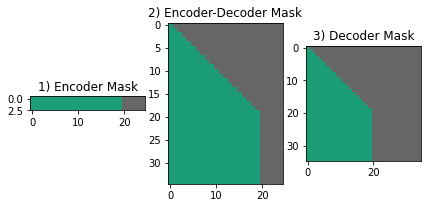

In [22]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

### Step4. 훈련하기

앞서 필요한 것들을 모두 정의했기 때문에 우리는 훈련만 하면 됩니다! 아래 과정을 차근차근 따라가며 모델을 훈련하고, 예문에 대한 멋진 번역을 제출하세요!

1. 2 Layer를 가지는 Transformer를 선언하세요.
(하이퍼파라미터는 자유롭게 조절합니다.)

In [23]:
transformer = Transformer(
    n_layers=2, 
    d_model=512, 
    n_heads=8, 
    d_ff=2048, 
    src_vocab_size=SRC_VOCAB_SIZE, 
    tgt_vocab_size=TGT_VOCAB_SIZE, 
    pos_len=200
)

2. 논문에서 사용한것과 동일한 <b>Learning Rate Scheduler</b>를 선언하고 이를 포함하는 <b>Adam Optimizer</b>를 선언해라. (Optimizer의 파라미터 역시 논문과 동일하게 설정한다.)

In [24]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


3. <b>Loss 함수를 정의</b>해라. <br>
Seq-to-seq 모델에서 사용했던 Loss와 유사하되, <b>Masking 되지 않은 입력의 개수로 Scaling</b>하는 과정을 추가한다. (트랜스포머가 모든 입력에 대한 Loss를 한번에 구하기 때문이다.)

In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

4. <b>train_step 함수</b>를 정의해라. <br>
<b> 입력 데이터에 알맞은 Mask를 생성</b>하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 한다. 

In [26]:
# Train Step 함수 정의

#@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

5. <b>학습을 진행</b>한다. <br>
<b> 매 Epoch 마다 제시된 예문에 대한 번역을 생성</b>하고, 멋진 번역이 생성되면 그때의 <b>하이퍼파라미터와 생성된 번역을 제출</b>하세요!

예문) <br>
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

In [28]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [29]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [30]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [31]:
# 학습

from tqdm import tqdm_notebook 
BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]


for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE], dec_train[idx:idx+BATCH_SIZE], transformer, optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_7747/1440939341.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a greatest.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s largest economy is to be in the city.
Input: 커피는 필요 없다.
Predicted translation: the film s best.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were killed in the capital.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president barack obama is a big story
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a similar to the city.
Input: 커피는 필요 없다.
Predicted translation: it s not just a long time.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the attack occurred shortly after the death toll was caused by the death toll.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of san francisco city.
Input: 커피는 필요 없다.
Predicted translation: coffee don t have any coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven member of the seven people were killed and seven were killed.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the housing is in cities.
Input: 커피는 필요 없다.
Predicted translation: coffee is not a coffee coffee coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the street is the old town.
Input: 커피는 필요 없다.
Predicted translation: otherwise.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven days of the death


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the nation s old cities is not a huge urban city.
Input: 커피는 필요 없다.
Predicted translation: it doesn t necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed in the raid.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is on tour
Input: 시민들은 도시 속에 산다.
Predicted translation: the row also prompted outrage among the animals.
Input: 커피는 필요 없다.
Predicted translation: coffee is necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a death toll in seven days has killed seven people, it added.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: they want cities to reach the old.
Input: 커피는 필요 없다.
Predicted translation: coffee does.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven aboard were wounded.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is looking for obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is now on the old city.
Input: 커피는 필요 없다.
Predicted translation: the need body just wants to make a coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed, seven people 8212


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama will be president.
Input: 시민들은 도시 속에 산다.
Predicted translation: they are busy in old cities.
Input: 커피는 필요 없다.
Predicted translation: need to necessary pay
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is approaching president.
Input: 시민들은 도시 속에 산다.
Predicted translation: they want to urban areas.
Input: 커피는 필요 없다.
Predicted translation: necessary to need necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and the death toll monday takes to rise.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is ready.
Input: 시민들은 도시 속에 산다.
Predicted translation: they want to cities.
Input: 커피는 필요 없다.
Predicted translation: need to need for helicopter.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed, the death toll could not be confirmed.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is encouraging
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens have cities around the world.
Input: 커피는 필요 없다.
Predicted translation: the coffee provides a need for need.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen killed were killed in a raid.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it is obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: they were across the city.
Input: 커피는 필요 없다.
Predicted translation: if necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people killed seven people, it said.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is approaching president.
Input: 시민들은 도시 속에 산다.
Predicted translation: they have to find myself.
Input: 커피는 필요 없다.
Predicted translation: coffee is need to be suit.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed, it said.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is eager to see obama
Input: 시민들은 도시 속에 산다.
Predicted translation: traffic jamal photos traffic
Input: 커피는 필요 없다.
Predicted translation: the coffee c civilians.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen others were killed, the death toll stood and the death toll stood.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is bidding on tour
Input: 시민들은 도시 속에 산다.
Predicted translation: they survived these cities shoes.
Input: 커피는 필요 없다.
Predicted translation: the necessary necessary coffee is needed.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died while the death toll stood.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is on his first term.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the old city.
Input: 커피는 필요 없다.
Predicted translation: coffee is needed.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the death.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is expecting david.
Input: 시민들은 도시 속에 산다.
Predicted translation: they want urban to create the old city.
Input: 커피는 필요 없다.
Predicted translation: needs to necessary coffee, coffee is needed.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed in a school attack.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is bidding on march 8.
Input: 시민들은 도시 속에 산다.
Predicted translation: traffic michigan has a haven t been here.
Input: 커피는 필요 없다.
Predicted translation: needs to be needed.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen countries have been killed.


결과 (output) <br>
Translations <br>
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks . <br><br>

Hyperparameters <br>
> n_layers: 2 <br>
> d_model: 512 <br>
> n_heads: 8 <br>
> d_ff: 2048 <br>
> dropout: 0.3 <br><br>

Training Parameters <br>
> Warmup Steps: 4000  <br>
> Batch Size: 64 <br>
> Epoch At: 5

translate() 함수의 plot_attention 변수를 True 로 주면 <b>번역 결과에 대한 Attention Map을 시각화</b> 해볼 수 있습니다.

In [32]:
example_sentence = "무슨 영화를 제일 좋아하나요? 부귀영화요"
translate(example_sentence, transformer, ko_tokenizer, en_tokenizer)

Input: 무슨 영화를 제일 좋아하나요? 부귀영화요
Predicted translation: what the one s talk about the film ⁇ 


In [33]:
example_sentence = "자바를 잡아라"
translate(example_sentence, transformer, ko_tokenizer, en_tokenizer)

Input: 자바를 잡아라
Predicted translation: 4.


In [34]:
example_sentence = "너는 지금 촉이와 상태? 나는 지금 초기화 상태"
translate(example_sentence, transformer, ko_tokenizer, en_tokenizer)

Input: 너는 지금 촉이와 상태? 나는 지금 초기화 상태
Predicted translation: now, i hope come between the state and the notice in a report there.


In [35]:
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')  # 리눅스의 경우 나눔고딕 폰트를 사용하도록 변경해주세요.

# 그래프에서 마이너스 기호가 표시되도록 설정
plt.rc('axes', unicode_minus=False)

Input: 오바마는 대통령이다.
Predicted translation: president obama is bidding on march 8.
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


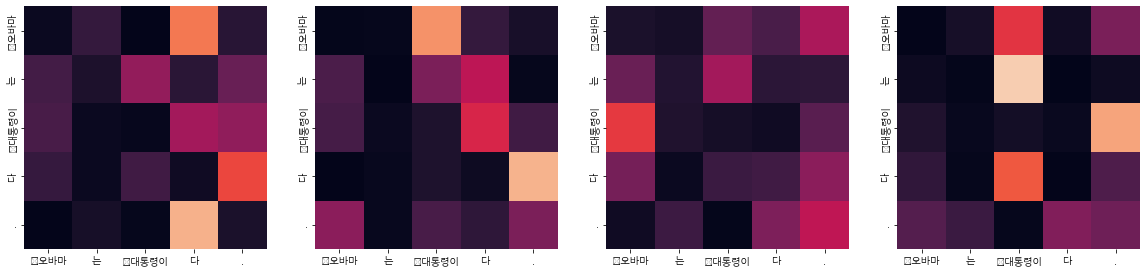

Encoder Layer 2


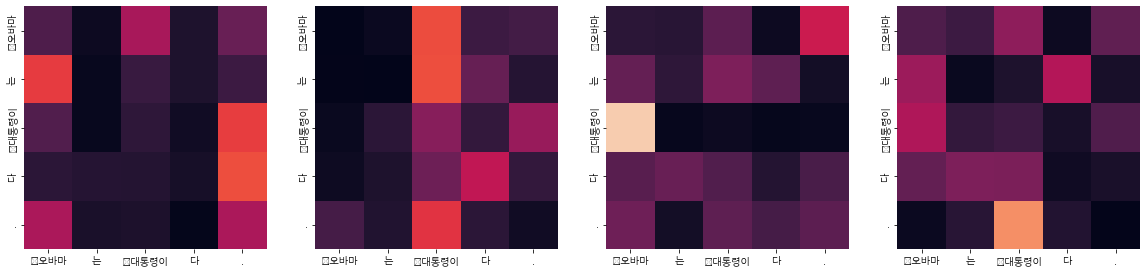

Decoder Self Layer 1


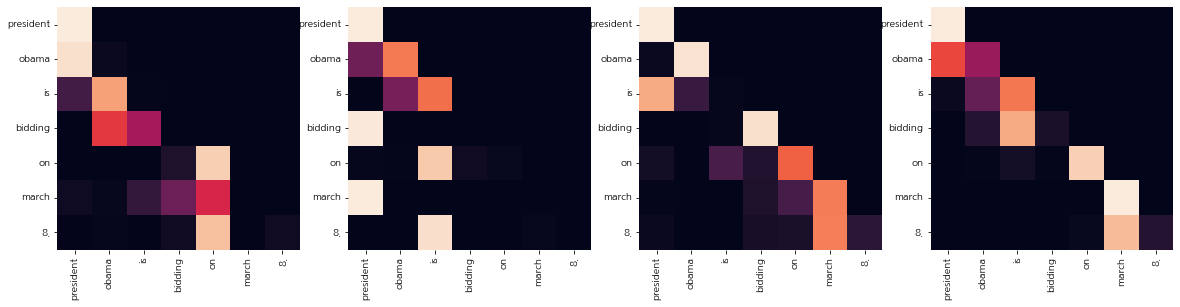

Decoder Src Layer 1


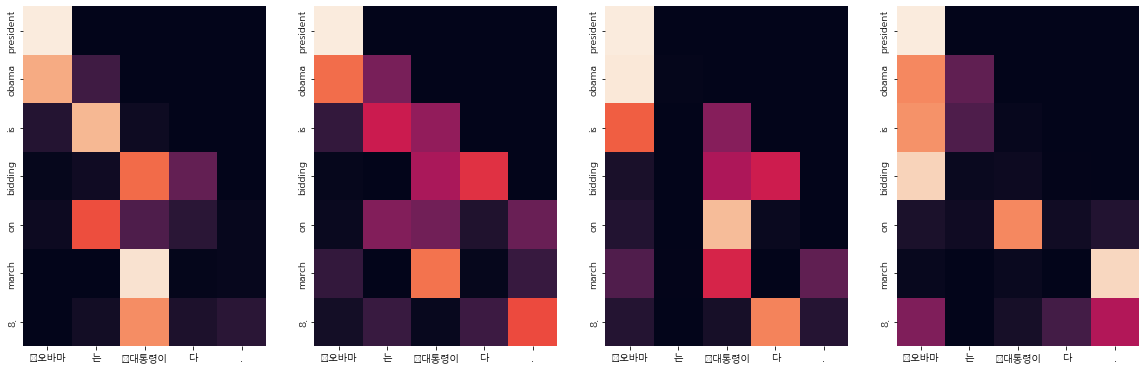

Decoder Self Layer 2


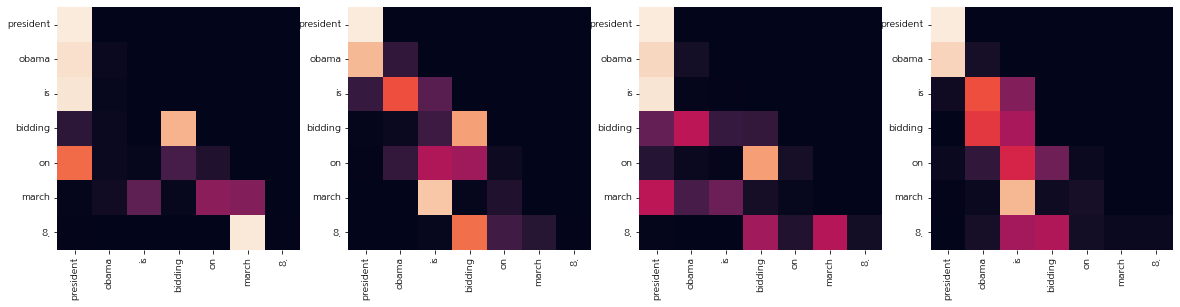

Decoder Src Layer 2


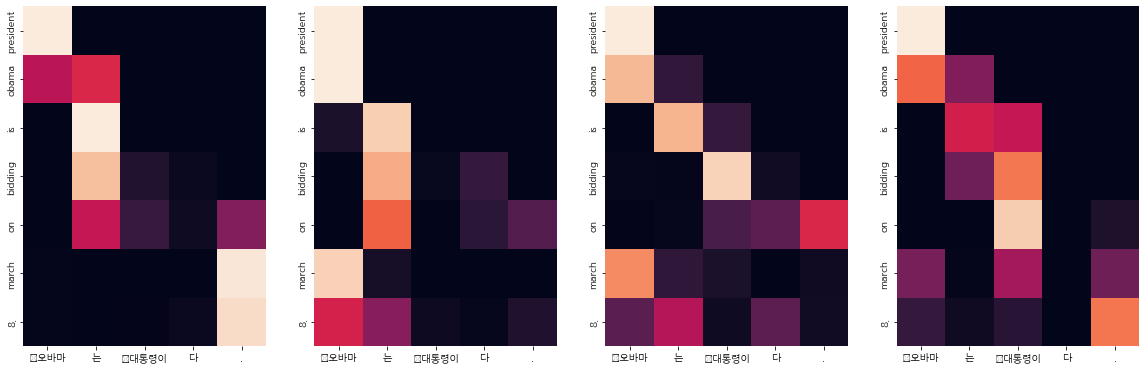

Input: 시민들은 도시 속에 산다.
Predicted translation: traffic michigan has a haven t been here.
Encoder Layer 1


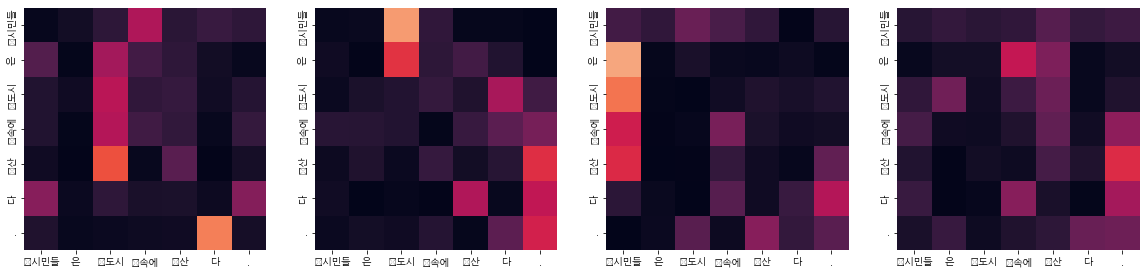

Encoder Layer 2


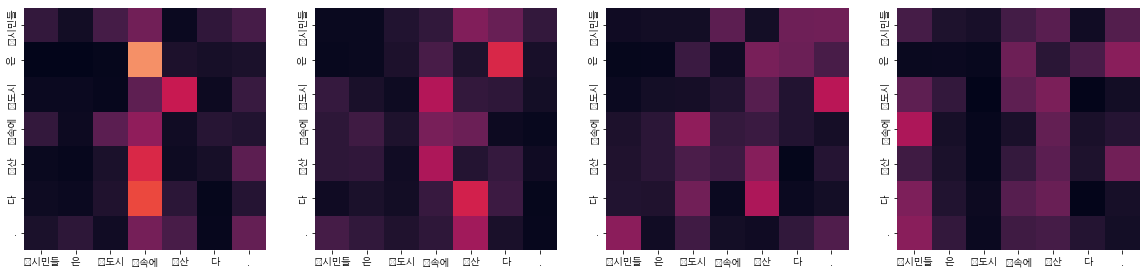

Decoder Self Layer 1


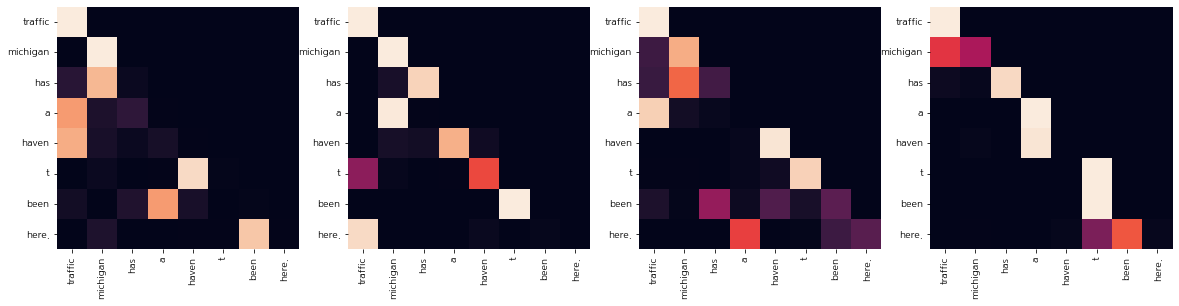

Decoder Src Layer 1


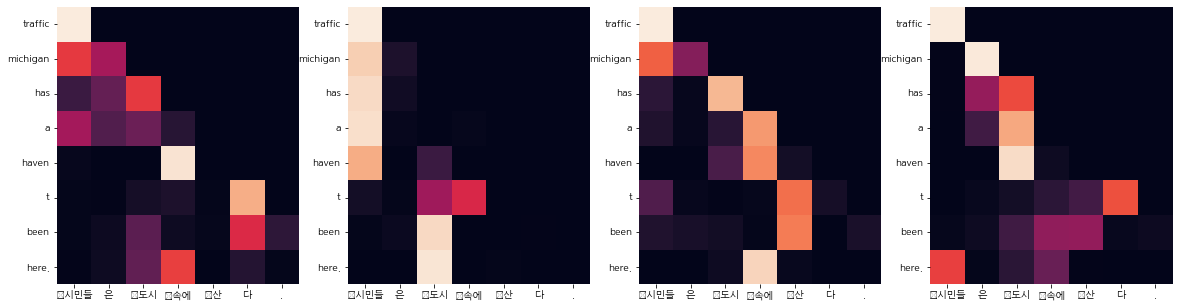

Decoder Self Layer 2


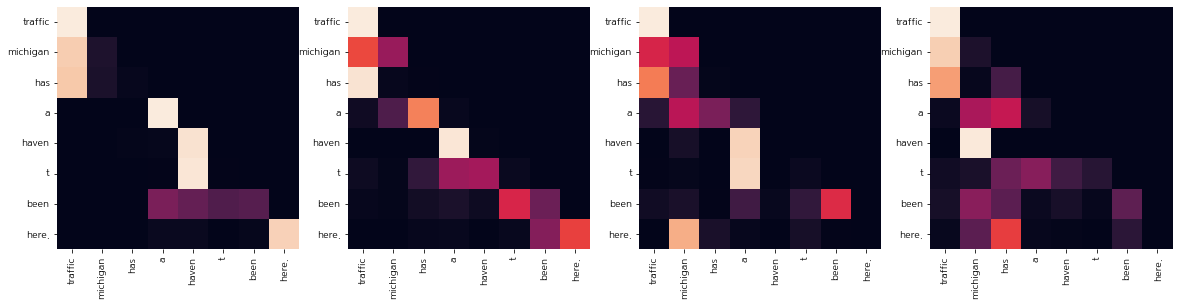

Decoder Src Layer 2


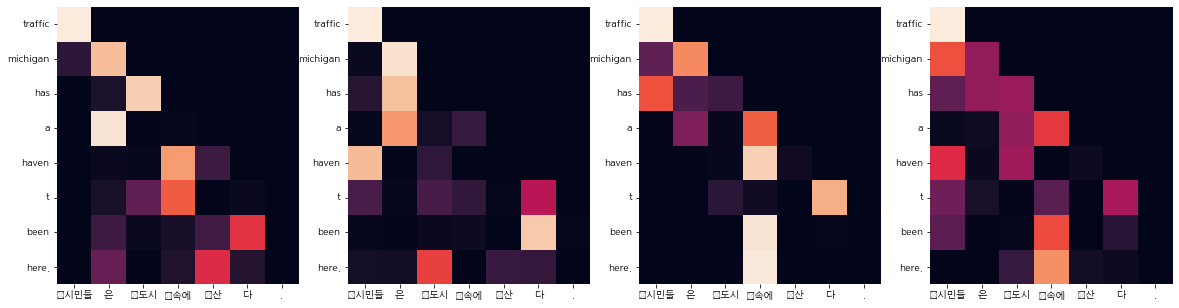

Input: 커피는 필요 없다.
Predicted translation: needs to be needed.
Encoder Layer 1


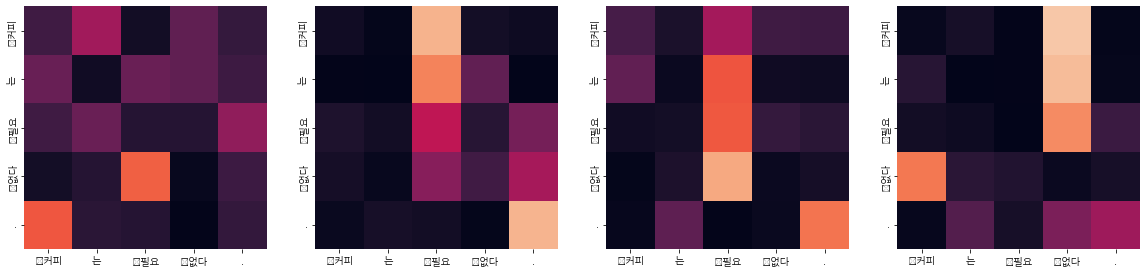

Encoder Layer 2


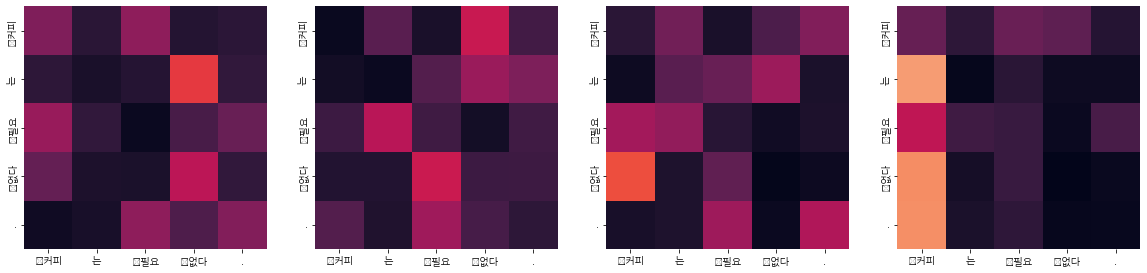

Decoder Self Layer 1


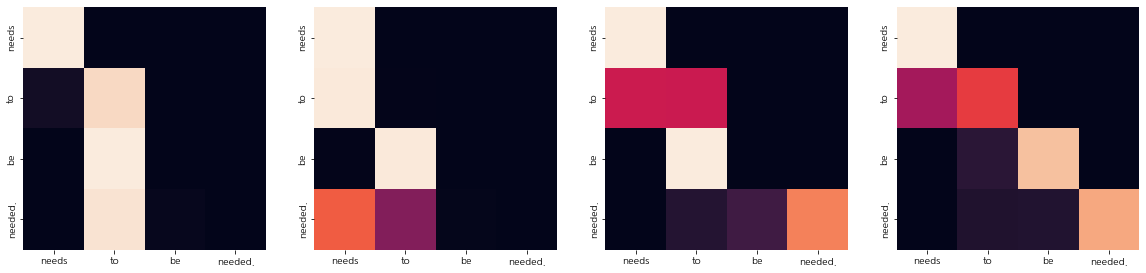

Decoder Src Layer 1


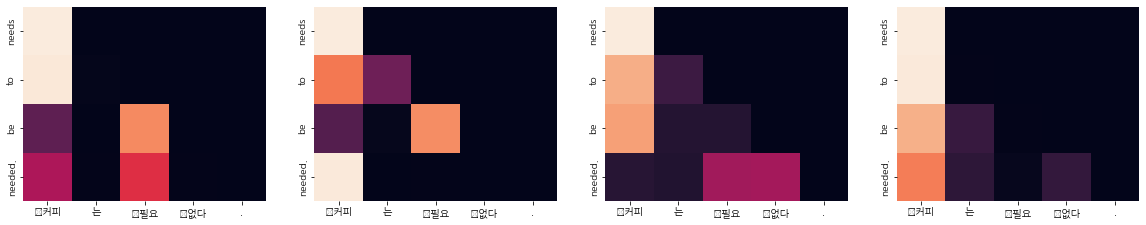

Decoder Self Layer 2


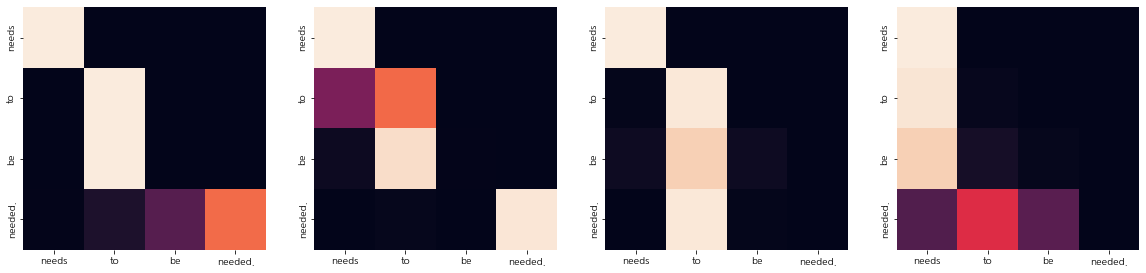

Decoder Src Layer 2


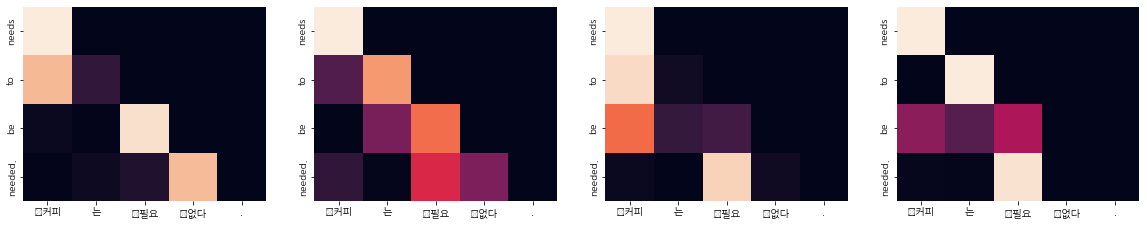

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen countries have been killed.
Encoder Layer 1


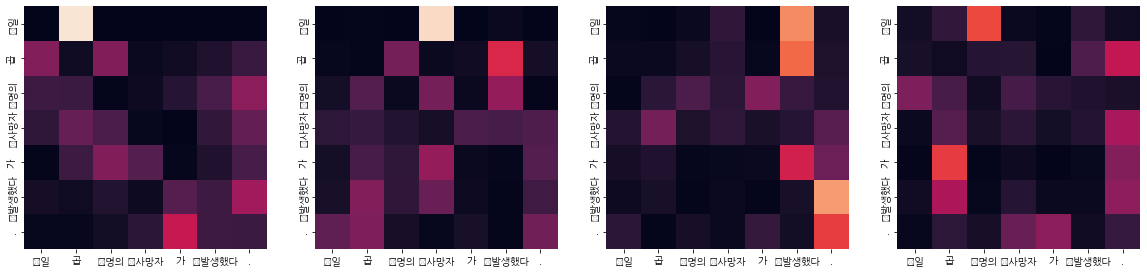

Encoder Layer 2


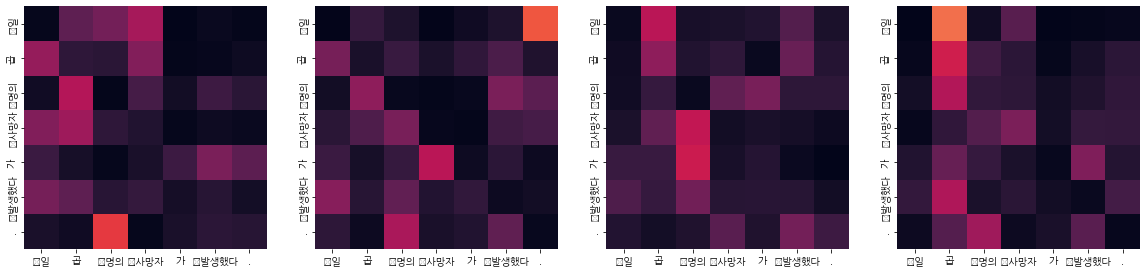

Decoder Self Layer 1


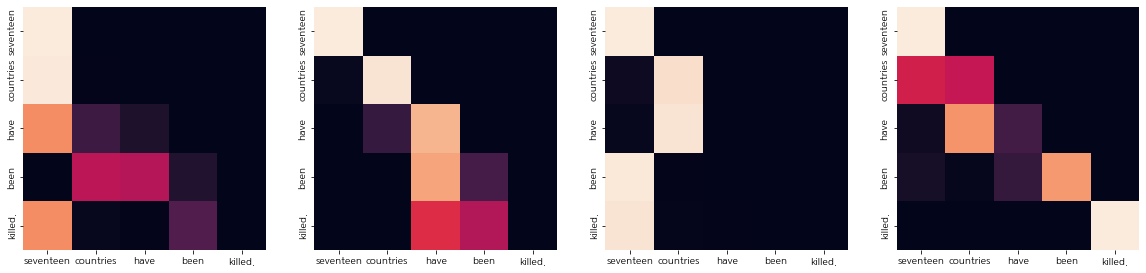

Decoder Src Layer 1


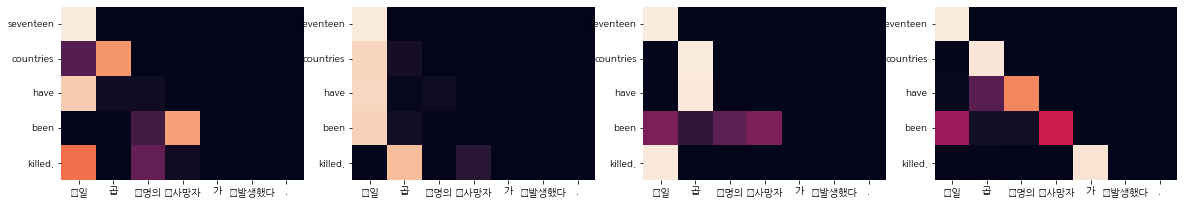

Decoder Self Layer 2


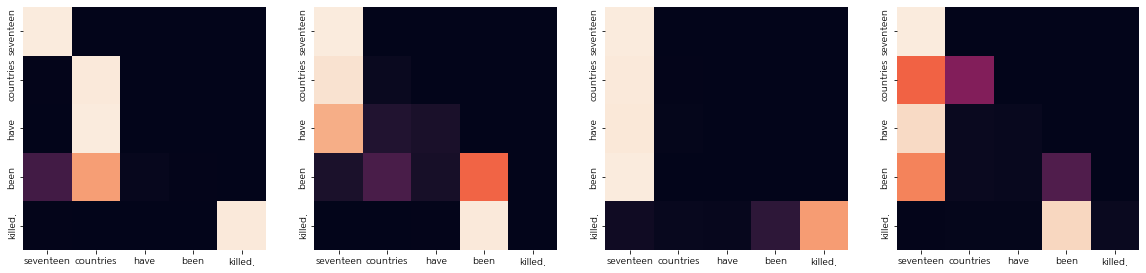

Decoder Src Layer 2


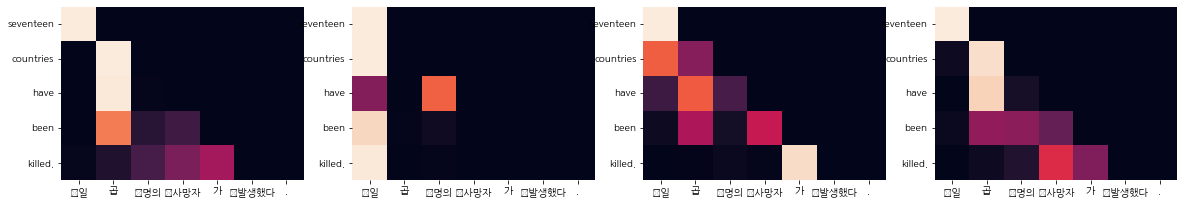

In [37]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

회고:
- 로스값이 떨어진다고 번역이 더 정확하게 된느 것은 아니다..
- 오바마는 대통령이다 <-- 이 문장만은 로스값이 떨어질수록 확실히 번역이 잘 된다. 